#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [308]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [309]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {} # {class=0: {feature_index=0: {feature_value=0: 0.666, ... }, ... }, ... }

    def build_classifier(self, train_features, train_classes):
        class_counter = Counter(train_classes)
        self.priors = {key: class_items_number / len(train_classes) for key, class_items_number in class_counter.items()}
        train_features_discrete = self.data_discretization(train_features)
        data = np.column_stack((train_features_discrete, train_classes))  # entend train_features with train_classes
        sorted_indices = np.argsort(data[:, -1])  # sort by train_classes values
        data = data[sorted_indices]
        sorted_classes = sorted(class_counter.keys())
        first_iteration = True
        for _class in sorted_classes:
            self.likelihoods[_class] ={}
            if first_iteration:
                first_row = 0
                last_row = class_counter[_class]
                first_iteration = False
            else:
                first_row = last_row
                last_row = first_row + class_counter[_class]

            one_class_features = data[first_row:last_row, :-1]
            for column_index in range(one_class_features.shape[-1]):
                feature_counter = Counter(one_class_features[:,column_index])
                self.likelihoods[_class][column_index] = {key: feature_items_number / len(one_class_features) for key, feature_items_number in feature_counter.items()}



    def data_discretization(self, data, number_of_discrete_values=4):
        new_data = np.zeros_like(data, dtype='int32')
        self.discrete_boundaries = np.zeros([data.shape[-1], number_of_discrete_values-1])
        for column_index in range(data.shape[-1]):
            max_column_value = np.max(data[:,column_index])
            min_column_value = np.min(data[:,column_index])
            disrete_range = (max_column_value-min_column_value) * 1/number_of_discrete_values
            self.discrete_boundaries[column_index] = np.linspace(min_column_value, max_column_value, number_of_discrete_values+1)[1:-1]
            new_data[:, column_index] = np.digitize(data[:, column_index], self.discrete_boundaries[column_index], right=True).astype('int32')
        return new_data

    def sample_discretization(self, sample):
        return np.array([np.digitize(feature, self.discrete_boundaries[i], right=True).astype('int32') for i,feature in enumerate(sample)])

    def predict(self, sample):
        discrete_sample = self.sample_discretization(sample)
        class_probablities = {}
        for _class in self.priors.keys():
            # add /P(B) - normalization somewhere here
            probability = self.priors[_class]
            for feature_index, feature_value in enumerate(discrete_sample):
                try:
                    probability *= self.likelihoods[_class][feature_index][feature_value]
                except KeyError:
                    probability *= 0
            class_probablities[_class] = probability
        return max(class_probablities, key=class_probablities.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {} # {class=0: {feature_index=0: [mean, std], ...}, ... }

    def build_classifier(self, train_features, train_classes):
        class_counter = Counter(train_classes)
        self.priors = {key: class_item_number / len(train_classes) for key, class_item_number in class_counter.items()}
        data = np.column_stack((train_features, train_classes))  # entend train_features with train_classes
        sorted_indices = np.argsort(data[:, -1])  # sort by train_classes values
        data = data[sorted_indices]
        sorted_classes = sorted(class_counter.keys())
        first_iteration = True
        for _class in sorted_classes:
            self.likelihoods[_class] ={}
            if first_iteration:
                first_row = 0
                last_row = class_counter[_class]
                first_iteration = False
            else:
                first_row = last_row
                last_row = first_row + class_counter[_class]

            one_class_features = data[first_row:last_row, :-1]
            for column_index in range(one_class_features.shape[-1]):
                mean = np.mean(one_class_features[:,column_index])
                std = np.sqrt(np.mean(np.power(one_class_features[:,column_index],2)) - np.power(mean, 2))
                self.likelihoods[_class][column_index] = [mean, std]

    @staticmethod
    def normal_dist(x, mean, std):
        return (1/(std*np.sqrt(2*np.pi))) * np.exp((-np.power(x-mean, 2))/(2*np.power(std, 2)))

    def predict(self, sample):
        class_probablities = {}
        for _class in self.priors.keys():
            # add /P(B) - normalization somewhere here
            probability = self.priors[_class]
            for feature_index, feature_value in enumerate(sample):
                mean, std = self.likelihoods[_class][feature_index]
                probability *= self.normal_dist(feature_value, mean, std)

            class_probablities[_class] = probability
        return max(class_probablities, key=class_probablities.get)

In [310]:
n = NaiveBayes()
n.build_classifier(x_train, y_train)
for i,sample in enumerate(x_test):
    y_prediction = n.predict(sample)
    if y_test[i] == y_prediction:
        print("Success")
    else:
        print('Failure')

Success
Success
Success
Success
Success
Failure
Success
Success
Success
Success
Success
Success
Success
Success
Success


In [311]:
g = GaussianNaiveBayes()
g.build_classifier(x_train, y_train)
for i,sample in enumerate(x_test):
    y_prediction = g.predict(sample)
    if y_test[i] == y_prediction:
        print("Success")


Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success
Success


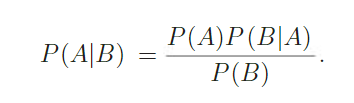

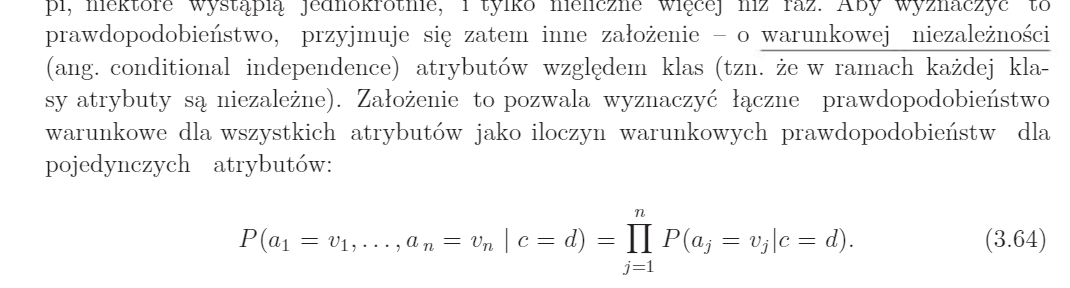